In [1]:
import sys
sys.path.append("..")

import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import seaborn as sns
import pandas as pd

from src.data.landslides_datamodule import GlobalLandslideDataModule
from src.models.landslide_module import LandslideEnsemble
from performance_diagram import PerformanceDiagram as PD
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Setup dataset folder and pretrained model folder
Both data and pretrained models can be downloaded from Zenodo, see tha `data` and `models` folder for info and scripts for data download.

In [2]:
# change as needed if you saved the model or the data in a different location
data_dir = "../data/global_dataset"
model_dir = "../models"

### Load all 4 ensemble confugirations and compute performances on the test area
This step takes a while since it computes the perfomances for all 360 enseble configurations.
Running it on a GPU equipped environment is suggested.

In [ ]:
top_k = 90
titles = ["Sentinel 1", "Sentinel 2", "Sentinel 1 + 2", "All channels"]
fnames = ["s1", "s2", "s1_s2", "all"]
folders = ["sentinel1_ensemble", "sentinel2_ensemble", "sentinel1_and_2_ensemble", "all_ch_ensemble"]
summaries = []

for title, fname, folder in zip(titles, fnames, folders):
    models = LandslideEnsemble.load_best_models_from_multirun(
        f"{model_dir}/{folder}/", n=top_k,
    )
    ensemble = LandslideEnsemble(models).to(device)
    ensemble_summary = ensemble.ensemble_summary()


    dm = GlobalLandslideDataModule(
        train_input_dir=data_dir + "/train_val/input",
        train_label_dir=data_dir + "/train_val/label",
        test_input_dir=data_dir + "/test/input",
        test_label_dir=data_dir + "/test/label",
        batch_size=1,
        num_workers=1,
        random_crop=256,
        random_flip=True,
        normalize=True,
        in_memory=True,
        pin_memory=True,
        train_val_split=0.8,
        samples_per_epoch=1000,
        channels=ensemble.models[0].hparams.cfg.data.channels
        if hasattr(ensemble.models[0].hparams.cfg.data, "channels")
        else None,
    )
    dm.setup()
    dl = dm.test_dataloader()
    data = next(iter(dl))
    label = data[1]
    lbl = label.round().type(torch.int8)
    label_flat = lbl.cpu().numpy().squeeze().flatten()
    data[0].shape

    ens_precisions = []
    ens_recalls = []
    ens_f1s = []
    precisions = []
    recalls = []
    f1s = []
    with torch.no_grad():
        for k in range(1,top_k+1):
            # single model (k-th model)
            model = ensemble[k-1]
            result = torch.sigmoid(model(data[0].to(model.device))).round().type(torch.int8)
            result_flat = result.cpu().numpy().squeeze().flatten()
            f1 = f1_score(label_flat, result_flat, zero_division=0.)
            prec = precision_score(label_flat, result_flat, zero_division=0.)
            rec = recall_score(label_flat, result_flat, zero_division=0.)
            precisions.append(prec)
            recalls.append(rec)
            f1s.append(f1)
            print(f"Top {k} F1: {f1}")


            # ensemble (1 to k models)
            ens_result = ensemble(data[0], top_k=k).round().type(torch.int8)
            ens_result_flat = ens_result.cpu().numpy().squeeze().flatten()
            ens_f1 = f1_score(label_flat, ens_result_flat, zero_division=0.)
            ens_prec = precision_score(label_flat, ens_result_flat, zero_division=0.)
            ens_rec = recall_score(label_flat, ens_result_flat, zero_division=0.)
            ens_precisions.append(ens_prec)
            ens_recalls.append(ens_rec)
            ens_f1s.append(ens_f1)
            print(f"Top {k} ens F1: {ens_f1}")

    # add to summary
    ensemble_summary['ens_precision'] = ens_precisions
    ensemble_summary['ens_recall'] = ens_recalls
    ensemble_summary['ens_f1'] = ens_f1s
    ensemble_summary['precision'] = precisions
    ensemble_summary['recall'] = recalls
    ensemble_summary['f1'] = f1s
    # save to csv
    ensemble_summary.to_csv(f'{fname}_ensemble_summary.csv', index=False)

    summaries.append(ensemble_summary)
    del ensemble, models

### save the test results in a csv file

In [4]:
# concatenate all summary files into one file
df = pd.DataFrame()
for summary, title, fname, folder in zip(summaries, titles, fnames, folders):
    summary['title'] = title
    summary['fname'] = fname
    summary['folder'] = folder
    df = pd.concat([df, summary])
df.to_csv('model_performances.csv', index=False)
summaries = df

In [5]:
df

,model_number,model_score,loss,lr,net,ens_precision,ens_recall,ens_f1,precision,recall,f1,title,fname,folder
0,50,0.488478,SoftBCEWithLogitsLoss,0.001,PAN,0.864645,0.172470,0.287577,0.864645,0.172470,0.287577,Sentinel 1,s1,sentinel1_ensemble
1,26,0.478808,JaccardLoss,0.001,FPN,0.199904,0.367365,0.258917,0.147667,0.399233,0.215592,Sentinel 1,s1,sentinel1_ensemble
2,81,0.474301,SoftBCEWithLogitsLoss,0.010,UnetPlusPlus,0.829938,0.276483,0.414785,0.684606,0.174535,0.278157,Sentinel 1,s1,sentinel1_ensemble
3,72,0.455015,DiceLoss,0.001,Unet,0.815168,0.340956,0.480807,0.702612,0.496017,0.581510,Sentinel 1,s1,sentinel1_ensemble
4,2,0.452539,DiceLoss,0.001,DeepLabV3,0.830986,0.304662,0.445860,0.734047,0.273237,0.398237,Sentinel 1,s1,sentinel1_ensemble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,61,0.504282,SoftBCEWithLogitsLoss,0.010,PSPNet,0.815546,0.572735,0.672907,0.443209,0.634996,0.522045,All channels,all,all_ch_ensemble
86,14,0.429828,FocalLoss,0.001,DeepLabV3Plus,0.816593,0.572145,0.672855,0.919035,0.443789,0.598547,All channels,all,all_ch_ensemble
87,59,0.391105,LovaszLoss,0.010,PAN,0.820660,0.568457,0.671664,0.000000,0.000000,0.000000,All channels,all,all_ch_ensemble
88,34,0.290607,FocalLoss,0.001,Linknet,0.821573,0.568604,0.672073,0.825694,0.579374,0.680943,All channels,all,all_ch_ensemble


### Plot the performance of the ensemble with different ensemble size (number of models included in the ensemble)

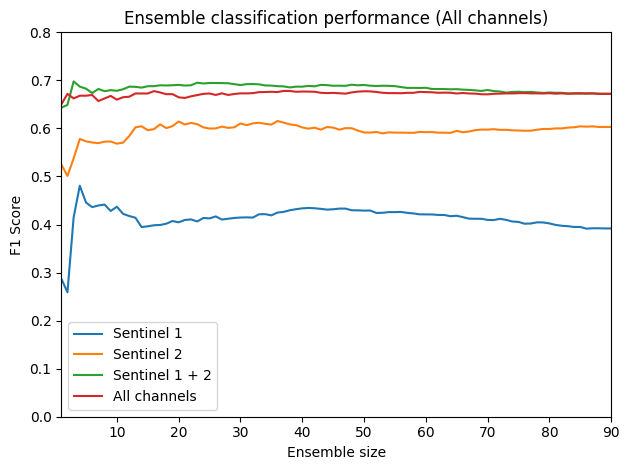

In [6]:
for fname in fnames:
    summary = summaries[summaries['fname'] == fname]
    sns.lineplot(x=range(1,top_k+1), y='ens_f1', data=summary, label=summary['title'].values[0])
plt.xlim([1, top_k])
plt.ylim([0, 0.8])
plt.xlabel('Ensemble size')
plt.ylabel('F1 Score')
plt.title(f'Ensemble classification performance ({title})')
plt.legend()
plt.tight_layout()
plt.savefig(f'ensembles_performance_f1.png')
plt.show()
plt.close()

### Plot the performance diagram

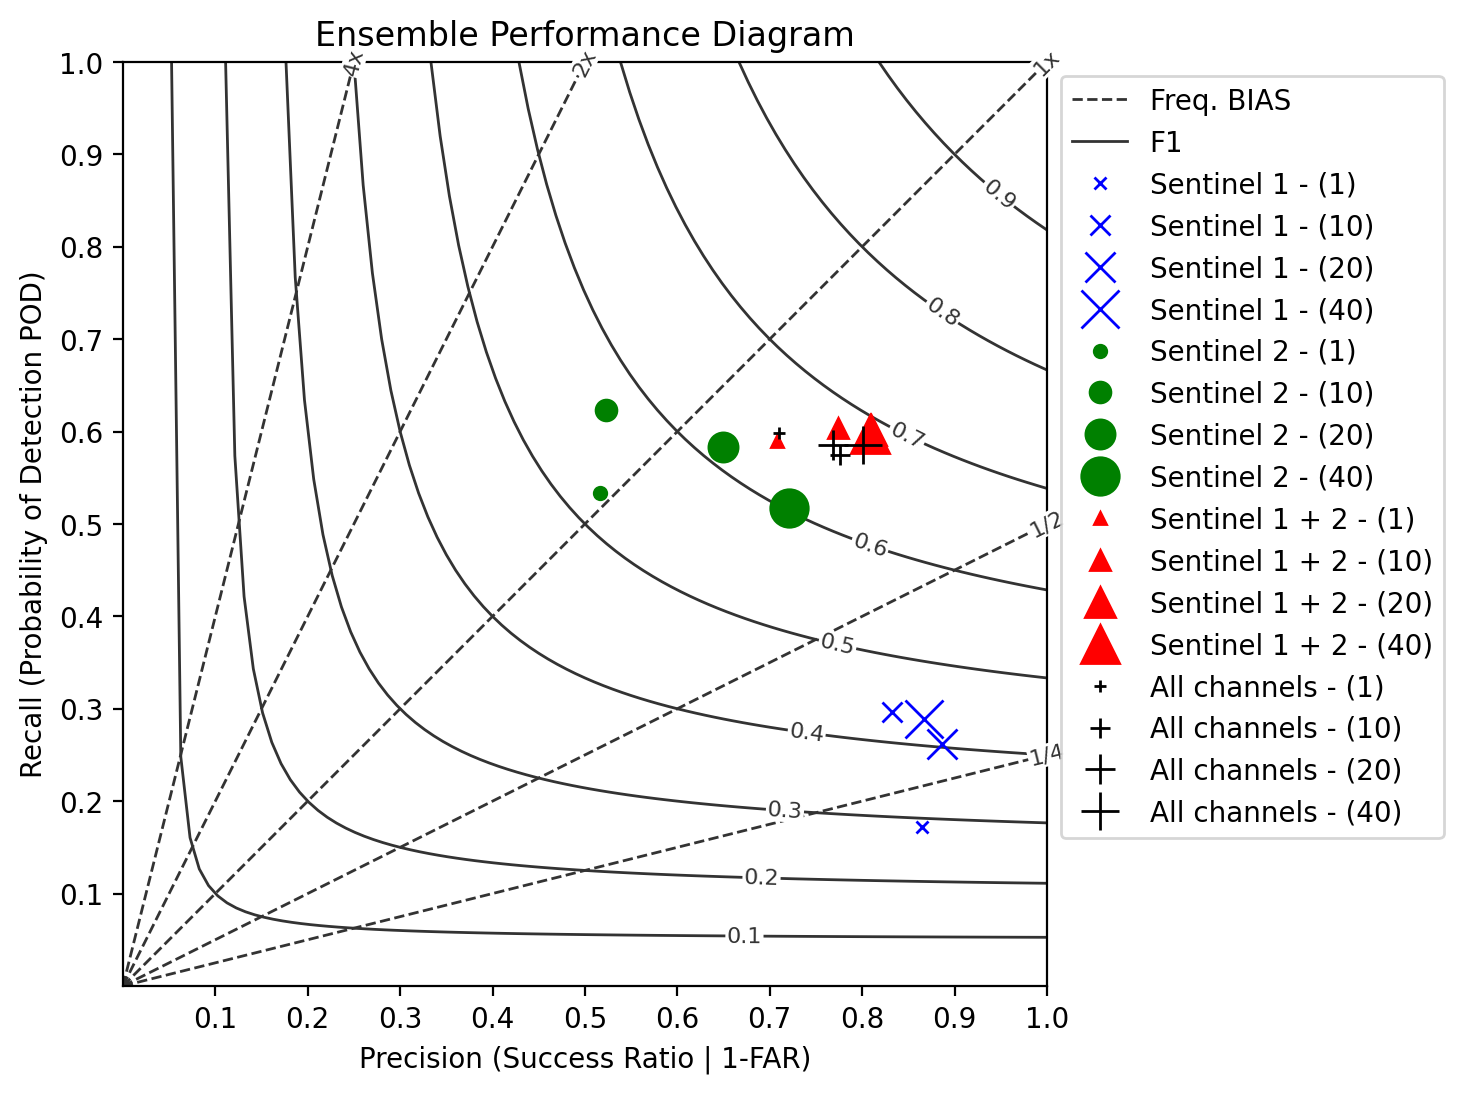

In [7]:
plt.figure(figsize=(6, 6), dpi=200)
pd = PD(
    perf_lines=dict(perf='f1'),
    perf_labels=dict(perf='f1'),
    title='Ensemble Performance Diagram',
    ylabel='Recall (Probability of Detection POD)',
)
ens_precisions = []
ens_recalls = []
legend_elements = []
markers = ['x','o','^','+','s','x','+','v','<','>','p','h','H','D','P','X']
colors = ['b','g','r','k','m','y','k','w']
for i,fname in enumerate(fnames):
    summary = summaries[summaries['fname'] == fname]
    title = summary["title"].values[0]
    elements = [0,9,19,39]
    for j,k in enumerate(elements):
        ens_precisions.append(summary['ens_precision'].values[k])
        ens_recalls.append(summary['ens_recall'].values[k])
        legend_elements.append(
            dict(
                label=f'{title} - ({k+1})',
                color=colors[i],
                marker=markers[i],
                linestyle='',
                markersize=(j+1.5)*3)
        )
pd.plot_data(
    1-np.array(ens_precisions),
    np.array(ens_recalls),
    legend_elements=legend_elements
)
plt.savefig(f'ensembles_performance_diagram.png')